In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import os
# import pyreadstat

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = '/content/drive/MyDrive/_data/BRFSS/'

In [ ]:
os.listdir(data_path)

['LLCP2018.XPT ',
 'LLCP2019.XPT ',
 'LLCP2020.XPT ',
 'LLCP2021.XPT ',
 'LLCP2022.XPT ',
 'Data_Xinya_0409.csv',
 'Data_all_0409.csv',
 'Data_CD_0409.csv',
 'Data_for_binary_0409.csv',
 'Data_CD_wiClasses.csv']

In [4]:
df = pd.read_csv(data_path+'Data_CD_wiClasses.csv')

In [5]:
mapping = {1:'Moderate', 2:'Mild', 3:'Severe'}
df.Class.replace(mapping, inplace=True)
# df.head()
mapping2 = {'Mild':0, 'Moderate':1, 'Severe':2}
df.Class.replace(mapping2, inplace=True)
# df.head()

In [ ]:
df.columns

Index(['X_SEX', 'X_AGE80', 'X_EDUCAG', 'X_INCOMG1', 'EMPLOY1', 'GENHLTH',
       'DEAF', 'BLIND', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'DECIDE',
       'X_MICHD', 'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ADDEPEV3', 'SMOKE100',
       'EXERANY2', 'CIMEMLOS', 'CDHOUSE', 'CDASSIST', 'CDSOCIAL', 'CDDISCUS',
       'American.Indian', 'Asian', 'Black', 'Hispanic', 'Mixed',
       'Native.Hawaiian', 'Others', 'White', 'Class'],
      dtype='object')

In [ ]:
def get_binary_columns(df):
    binary_columns = []
    for column in df.columns:
        unique_values = df[column].unique()
        if len(unique_values) == 2:
            binary_columns.append(column)
    return binary_columns

# binary_columns = get_binary_columns(X)
# cont_columns = [column for column in X.columns if column not in binary_columns]

In [25]:
X = df.drop(columns=['CIMEMLOS', 'CDHOUSE', 'CDASSIST', 'CDSOCIAL', 'CDDISCUS', 'Class', 'DECIDE'])
y = df.Class

In [7]:
from scipy.stats import pointbiserialr

cols = []
for col in X.columns:
  corr, _ = pointbiserialr(X[col], y)
  if abs(corr) > 0.1:
    cols.append(col)
  print(f"{col}: {corr}")


X_SEX: -0.07677697252718357
X_AGE80: -0.192292193858281
X_EDUCAG: -0.19346544476701988
X_INCOMG1: -0.3080950609032136
EMPLOY1: 0.20757114926176132
GENHLTH: 0.36960428045599775
DEAF: 0.07282683359118486
BLIND: 0.21047501430605392
DIFFWALK: 0.3489709363231034
DIFFDRES: 0.3641051417356519
DIFFALON: 0.47840941118785885
DECIDE: 0.4391616351047336
X_MICHD: 0.10109955587083261
CVDINFR4: 0.08783536570209077
CVDCRHD4: 0.08287663725198349
CVDSTRK3: 0.13716291754266102
ADDEPEV3: 0.3004701055894151
SMOKE100: 0.0642889765436655
EXERANY2: -0.20459907829859825
American.Indian: 0.056193617723844985
Asian: -0.021011540591767186
Black: 0.10448024085211506
Hispanic: 0.07820005459990254
Mixed: 0.02776867194405712
Native.Hawaiian: 0.007931417545279186
Others: 0.021710117288308767
White: -0.14511152517942366


In [ ]:
# X = X[cols]

In [26]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
split=list(enumerate(skf.split(df, df.Class)))
folds={i[0]:i[1][1] for i in split}
train_idx = np.concatenate((folds[0], folds[1], folds[2], folds[3]))
# val_idx = folds[3]
test_idx =  folds[4]

In [27]:
X_train = X.iloc[train_idx]
# X_val = X.iloc[val_idx]
X_test = X.iloc[test_idx]

y_train = y.iloc[train_idx]
# y_val = y.iloc[val_idx]
y_test = y.iloc[test_idx]


In [10]:
print(y_train.value_counts()/len(y_train))
print(y_test.value_counts()/len(y_test))

Class
0    0.541382
1    0.312895
2    0.145723
Name: count, dtype: float64
Class
0    0.541129
1    0.313085
2    0.145786
Name: count, dtype: float64


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


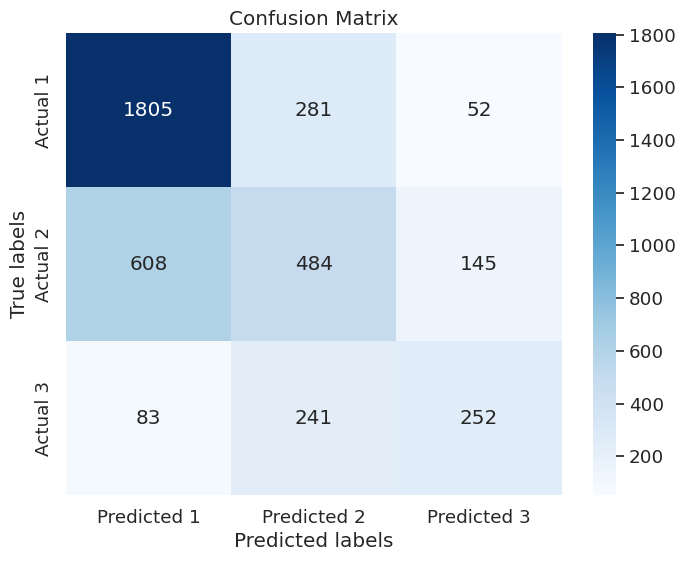

In [11]:
from sklearn.linear_model import LogisticRegression

# clf = LogisticRegression(class_weight={0:0.3,1:0.7})
clf = LogisticRegression()

clf.fit(X_train, y_train)
# y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.3).astype(int)
y_pred = clf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.set(font_scale=1.2)  # Adjust font size if needed
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 1', 'Predicted 2', 'Predicted 3'],
            yticklabels=['Actual 1', 'Actual 2', 'Actual 3'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [12]:
accuracy_score(y_test, y_pred)

0.6431283219438116

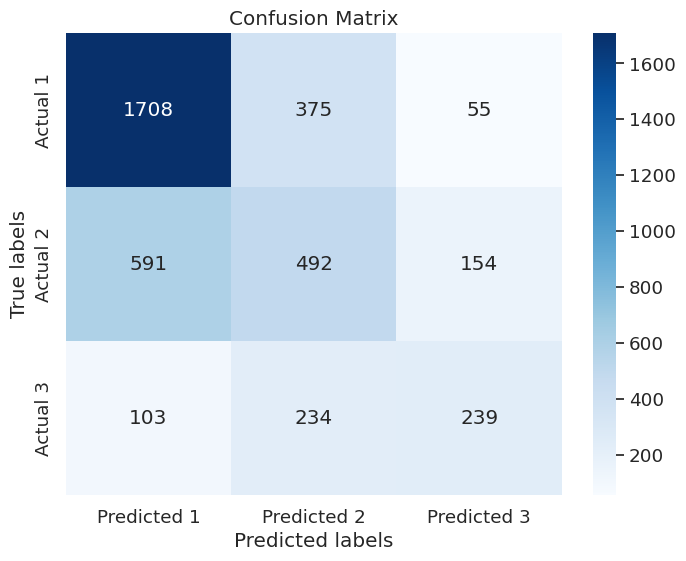

In [13]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.set(font_scale=1.2)  # Adjust font size if needed
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 1', 'Predicted 2', 'Predicted 3'],
            yticklabels=['Actual 1', 'Actual 2', 'Actual 3'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [14]:
accuracy_score(y_test, y_pred)

0.6173120728929385

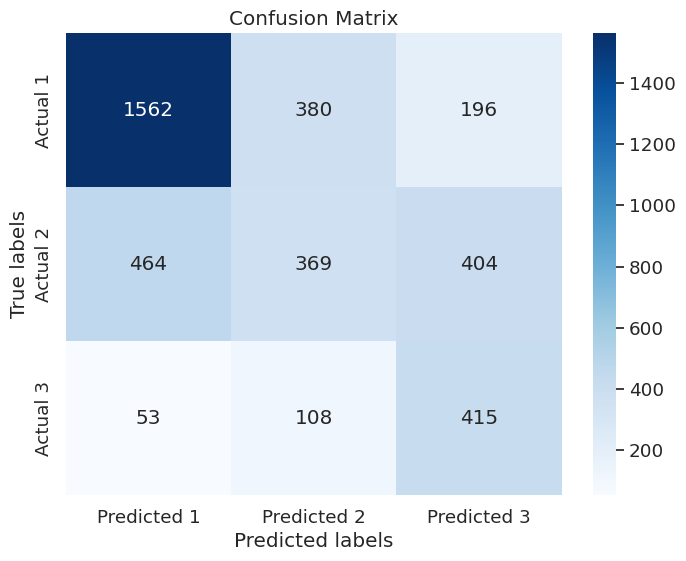

In [15]:
from sklearn.svm import SVC

clf = SVC(class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.set(font_scale=1.2)  # Adjust font size if needed
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 1', 'Predicted 2', 'Predicted 3'],
            yticklabels=['Actual 1', 'Actual 2', 'Actual 3'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [16]:
accuracy_score(y_test, y_pred)

0.5937737281700836

In [28]:
#@title MLP
import torch # torch

from torchvision import transforms # transform is used for data pre-processing
from torch.utils import data as Data
from torch.utils.data import Dataset # for dataset construction
from torch.utils.data import DataLoader

import torch.optim as optim

import numpy as np

import torch.nn as nn
import torch.nn.functional as F

In [29]:
XTrain = torch.from_numpy(X_train.values)
# XVal = torch.from_numpy(X_val.values)
XTest = torch.from_numpy(X_test.values)

yTrain = torch.from_numpy(y_train.values)
# yVal = torch.from_numpy(y_val.values)
yTest = torch.from_numpy(y_test.values)

In [30]:
min = torch.min(XTrain, dim = 0); max = torch.max(XTrain, dim = 0)
norm_dict_min_max = {'min': min[0], 'max': max[0]}

In [31]:
class MyDataset(Dataset):
  def __init__(self, X, y, norm_dict=None):
    self.X = X
    self.y = y
    self.norm_dict = norm_dict

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    if self.norm_dict is not None:
      min = self.norm_dict['min']
      max = self.norm_dict['max']
      X = (self.X[idx] - min) / (max - min)
    else:
      X = self.X[idx]
    return X, self.y[idx]

train_dataset = MyDataset(XTrain, yTrain, norm_dict = norm_dict_min_max)
# val_dataset = MyDataset(XVal, yVal)
test_dataset = MyDataset(XTest, yTest, norm_dict = norm_dict_min_max)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [32]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(XTrain.shape[1], 256)
        # self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        # self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 64)
        # self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(64, 32)
        # self.dropout4 = nn.Dropout(0.5)
        self.fc5 = nn.Linear(32, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        # x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        # x = self.dropout3(x)
        x = F.relu(self.fc4(x))
        # x = self.dropout4(x)
        x = self.fc5(x)
        return x

In [35]:
model = SimpleMLP()

loss = nn.CrossEntropyLoss(weight=torch.tensor(sum(y_train)/(np.bincount(y_train)*2), dtype=torch.float32))
# loss = nn.CrossEntropyLoss()
# loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
for i in range(epochs):
  model.train()
  train_acc, val_acc = [], []

  true_labs, pred_labs = [], []
  for batch, (X, y) in enumerate(train_loader):
    X = X.float()
    optimizer.zero_grad()
    outputs = model(X)

    loss_value = loss(outputs, y)
    loss_value.backward()
    optimizer.step()

    y_pred = torch.argmax(outputs, dim=1).cpu().numpy()
    y_true = y.cpu().numpy()

    true_labs.extend(y_true)
    pred_labs.extend(y_pred)

  train_acc.append(accuracy_score(true_labs, pred_labs))
  if i % 10 == 0:
    print(f'Epoch: [{i+1}/{epochs}]: training accuracy is {train_acc[-1]:.4f}')

  model.eval()
  true_labs, pred_labs = [], []
  for batch, (X, y) in enumerate(test_loader):
    X = X.float()
    outputs = model(X)

    y_pred = torch.argmax(outputs, dim=1).cpu().numpy()
    y_true = y.cpu().numpy()
    true_labs.extend(y_true)
    pred_labs.extend(y_pred)

  val_acc.append(accuracy_score(true_labs, pred_labs))
  if i % 10 == 0:
    print(f'Epoch: [{i+1}/{epochs}]: validation accuracy is {val_acc[-1]:.4f}')

Epoch: [1/100]: training accuracy is 0.5636
Epoch: [1/100]: validation accuracy is 0.5971
Epoch: [11/100]: training accuracy is 0.6085
Epoch: [11/100]: validation accuracy is 0.5834
Epoch: [21/100]: training accuracy is 0.6646
Epoch: [21/100]: validation accuracy is 0.5718
Epoch: [31/100]: training accuracy is 0.7332
Epoch: [31/100]: validation accuracy is 0.5730
Epoch: [41/100]: training accuracy is 0.7825
Epoch: [41/100]: validation accuracy is 0.5672
Epoch: [51/100]: training accuracy is 0.8250
Epoch: [51/100]: validation accuracy is 0.5475
Epoch: [61/100]: training accuracy is 0.8410
Epoch: [61/100]: validation accuracy is 0.5558
Epoch: [71/100]: training accuracy is 0.8577
Epoch: [71/100]: validation accuracy is 0.5500
Epoch: [81/100]: training accuracy is 0.8712
Epoch: [81/100]: validation accuracy is 0.5566
Epoch: [91/100]: training accuracy is 0.8902
Epoch: [91/100]: validation accuracy is 0.5576


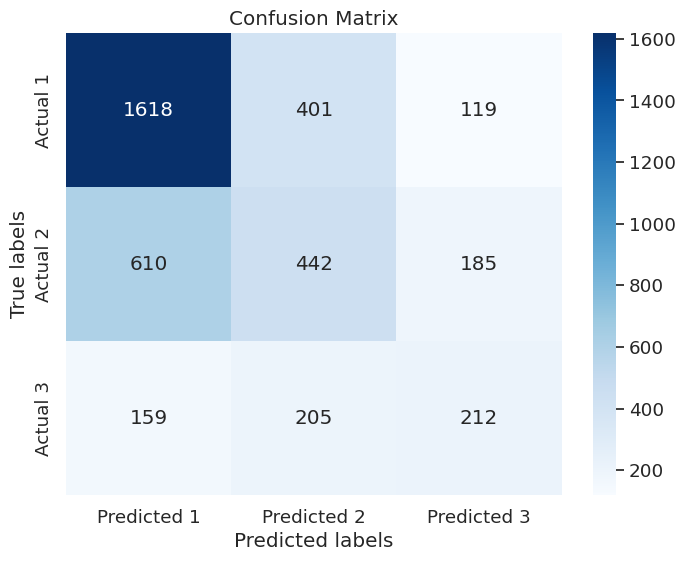

In [34]:
conf_matrix = confusion_matrix(true_labs, pred_labs)

# Plot confusion matrix
sns.set(font_scale=1.2)  # Adjust font size if needed
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 1', 'Predicted 2', 'Predicted 3'],
            yticklabels=['Actual 1', 'Actual 2', 'Actual 3'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# import os
# from google.colab import drive
# drive.mount('/content/drive')
# data_path = '/content/drive/MyDrive/Colab Notebooks/Data Mining/Data'
# df14.to_csv(os.path.join(data_path, 'Data_Xinya_0408.csv'), index=False)
# # os.listdir(data_path)

In [ ]:
# df=pd.read_csv('https://drive.google.com/uc?export=download&id=12KieiuP24jrrpTQqT4lj9L5iUXyr63s1')
